## Exporting the modules 

In [1]:
using Printf
using Oceananigans
using Oceananigans.Utils
using Oceananigans.Units: minute, minutes, hour
using Oceananigans.Grids: nodes
using Oceananigans.Diagnostics
using Oceananigans.OutputWriters: JLD2OutputWriter, FieldSlicer, TimeInterval
using Oceananigans.Diagnostics: accurate_cell_advection_timescale

## Defining Grid

In [4]:
#number of grid spacing in south,north and vertical direction
const Nx=256
const Ny=256
const Nz=64

#Length of grid in south, north and vertical direction
const Lx=4
const Ly=4
const Lz=0.1

const S = 1.6 # Stretching factor
hyperbolically_spaced_nodes(k) = -Lz-Lz*(tanh(S * ( (-(k-Nz-1) ) / Nz - 1)) / tanh(S))
computational_grid = VerticallyStretchedRectilinearGrid(size = (Nx, Ny, Nz), 
                                                               architecture = CPU(),
                                                               x = (0,Lx),
                                                               y = (0,Ly),
                                                               halo = (3, 3, 3),
                                                               z_faces = hyperbolically_spaced_nodes)


VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded}
                   domain: x ∈ [0.0, 4.0], y ∈ [0.0, 4.0], z ∈ [-0.1, 0.0]
                 topology: (Periodic, Periodic, Bounded)
  resolution (Nx, Ny, Nz): (256, 256, 64)
   halo size (Hx, Hy, Hz): (3, 3, 3)
grid spacing (Δx, Δy, Δz): (0.015625, 0.015625, [min=0.0004178411847718111, max=0.0027119068833282023])

## Governing parameters

In [5]:
#Coefficient of Thermal expansion
const alpha= 2e-4

#Coefficient of Salinity
const beta=0

#diffusive viscocity
const v=1e-5 
#diffusivity
const k=2e-6 

const f=-0.5   #coriolis parameter

-0.5

## Boundary conditions

### Temperature(Tracer) boundary condition

In [52]:
Amplitude = 950 # Amplitude (W/m²) of Heat flux

Q_cool = -143.1092 # (W/m²) {due to Longwave + Latent heat + Sensible Heat}

gausian(t) =  exp(-((t)^2)/(0.025*(86400)^2)) 

# These are the times during which peak of the heat flux can be observed
peak1 = 0.56 * 24hour
peak2 = 1.56 * 24hour
peak3 = 2.56 * 24hour
peak4 = 3.56 * 24hour
peak5 = 4.56 * 24hour
peak6 = 5.56 * 24hour

# Heat absorbed due to shortwave
Q_sh(t) = Amplitude*(gausian(t-peak1) + gausian(t-peak2) + gausian(t-peak3) + gausian(t-peak4)+ gausian(t-peak5)+ gausian(t-peak6) )


Q_sh (generic function with 1 method)

In [53]:
Q_net(t) = Q_sh(t) + Q_cool

Q_net (generic function with 1 method)

In [54]:
0.56 * 24hour

48384.00000000001

In [55]:
function heatflux()
    if Q_net(t) <= 0
        bias = 1
        multiplier = 0
    else
        bias = 0
        multiplier = 1
    end
    
    return Q = bias*Q_cool
end

heatflux (generic function with 1 method)

In [70]:
t = 48384.00000000001
heatflux()

-0.0

In [61]:
dTdz = 0
T_bcs = FieldBoundaryConditions( top = FluxBoundaryCondition(heatflux()),
                                 bottom = GradientBoundaryCondition(dTdz))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Int64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

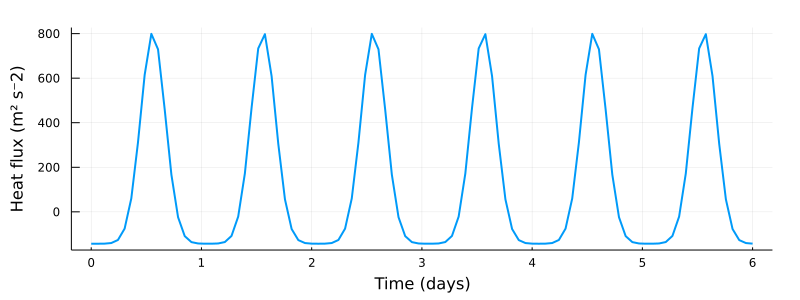

In [69]:
using Plots, Measures
using Oceananigans.Units: minutes, hour, hours, day
time = range(0, 6day, length=100)

flux_plot = plot(time ./ day, [Q_net(t) for t in time],
                 linewidth = 2, xlabel = "Time (days)", ylabel = "Heat flux (m² s⁻2)",
                 size = (800, 300), margin = 5mm, label = nothing)

### Defining Heat Source Term as a forcing

In [71]:
λ1 = 0.35
λ2 = 23.0
Ι = 0.58
ρ = 23 #random value
Cp = 23 #random value

function SortwavePenetration()
    for z = 0:N-1
        Q_band1(z) = (Ι/λ1)*exp(-z/λ1) 
        Q_band2(z) = (Ι/λ2)*exp(-z/λ2)
        if z <= 1
            cooling_source = multiplier*Q_cool/(ρ*Cp*Δz)
            T = T + Q_sh * (Q_band1(z) + Q_band2(z))/(ρ*Cp) + (cooling_source*Δz)
            
        else 
            T = T + Q_sh * (Q_band1(z) + Q_band2(z))/(ρ*Cp)
        end
    end
    
    return T
end

SortwavePenetration (generic function with 1 method)